# Load images


In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
def get_dataset(folder, image_size, batch_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1] range
    ])
    
    dataset = datasets.ImageFolder(root=folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

In [3]:
# load dataset
image_size = 128
batch_size = 32
folder = "pokemon_images/pokemon_jpg/"
dataloader = get_dataset(folder, image_size, batch_size)

for images, _ in dataloader:
    print(images.shape)
    break

torch.Size([32, 3, 128, 128])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


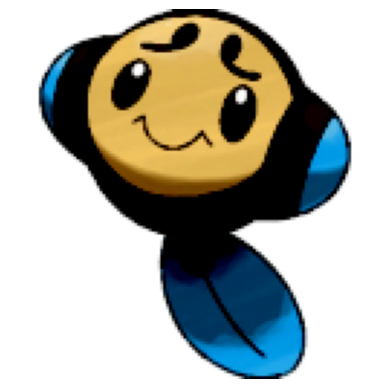

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


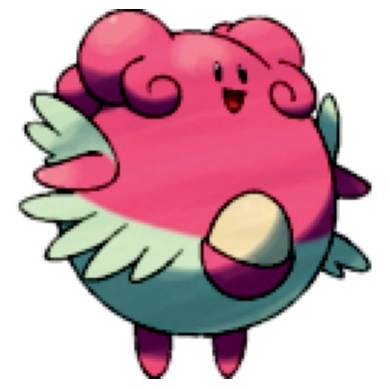

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


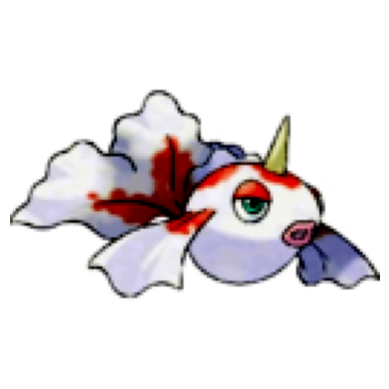

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


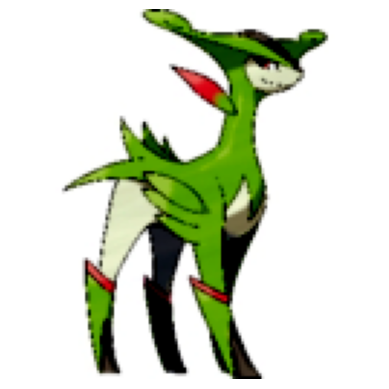

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


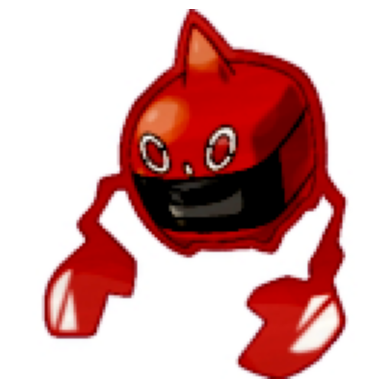

In [5]:
# visualize some images from dataloader
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(dataloader)
images, _ = next(dataiter)

# show images
for i in range(5):
    imshow(images[i])

# Discriminator

In [6]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # 128x128x3 -> 64x64x64
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # 64x64x64 -> 32x32x128
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32x128 -> 16x16x256
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(256, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16x256 -> 8x8x512
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(512, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8x512 -> 4x4x1024
            nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(1024, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Example usage
if __name__ == "__main__":
    # Create a random tensor with the shape (batch_size, channels, height, width)
    input_tensor = torch.randn((1, 3, 128, 128))
    
    # Create the discriminator
    discriminator = Discriminator()
    
    # Forward pass
    output = discriminator(input_tensor)
    
    print(output)


tensor([[0.5020]], grad_fn=<SigmoidBackward0>)


In [10]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (10): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1024, kernel_size=(5, 5

# Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        self.init_size = 8  # Initial size before upsampling
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 1024 * self.init_size * self.init_size)
        )
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(1024, momentum=0.1, eps=0.8),

            # 8x8x1024 -> 16x16x512
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=0.1, eps=0.8),
            nn.ReLU(inplace=True),

            # 16x16x512 -> 32x32x256
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.1, eps=0.8),
            nn.ReLU(inplace=True),

            # 32x32x256 -> 64x64x128
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.1, eps=0.8),
            nn.ReLU(inplace=True),

            # 64x64x128 -> 128x128x64
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.1, eps=0.8),
            nn.ReLU(inplace=True),

            # 128x128x64 -> 128x128x3
            nn.Conv2d(64, 3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 1024, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [9]:
# Example usage
if __name__ == "__main__":
    latent_dim = 100
    batch_size = 32

    # Create a random tensor with the shape (batch_size, latent_dim)
    noise = torch.randn(batch_size, latent_dim)
    
    # Create the generator
    generator = Generator(latent_dim)
    
    # Forward pass
    generated_images = generator(noise)
    
    print(generated_images.shape)  # Should be (batch_size, 3, 128, 128)

torch.Size([32, 3, 128, 128])


In [11]:
print(generator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), p